# HAR70+

In [102]:
import os
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from statistics import mode


In [103]:
def extract_zip(zip_path, extract_to):
    """
    Extracts a zip file to a specified directory.

    Args:
    zip_path (str): The path to the .zip file.
    extract_to (str): The directory where the contents will be extracted.

    Returns:
    bool: True if the extraction was successful, False otherwise.
    """
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)  # Create target directory if it doesn't exist

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Extracted all files in {zip_path} to {extract_to}")
        return True
    except zipfile.BadZipFile:
        print("Error: Bad ZIP file.")
    except FileNotFoundError:
        print("Error: ZIP file not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    return False

## Paths and variables

In [104]:
id_col = 'subject_id'
time_col = 'timestamp'
target_col = 'label'

In [105]:
dataset_handle = 'HAR70+'
dataset_name = 'har70plus'
processed_dir = './../../processed/'
output_dir = f'./../../processed/{dataset_name}/'
os.makedirs(output_dir, exist_ok=True)
full_outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
test_key_outp_fname = os.path.join(output_dir, f'{dataset_name}_test_key.csv')
train_outp_fname = os.path.join(output_dir, f'{dataset_name}_train.csv')
test_outp_fname = os.path.join(output_dir, f'{dataset_name}_test.csv')

## Read the data

In [106]:
if not os.path.exists('./data'):
    extract_zip(f'./data.zip', './')

files = os.listdir('data')
file_paths = [os.path.join('./data/', file) for file in files]
data = []
for file in file_paths:
    subject_id = int(Path(file).name.split('.')[0])
    df = pd.read_csv(file)
    df.insert(0, id_col, subject_id)
    data.append(df)

data = pd.concat(data)


Extracted all files in ./data.zip to ./


In [107]:
data[target_col] = data[target_col].astype(str)
data[time_col] = data[time_col].astype(str)


def quantize_df(data: pd.DataFrame , id_col:str , steps: int):

    def aggregate_group(group, steps=steps):

        numeric_cols = group.select_dtypes(include=[np.number]).columns
        object_cols = group.select_dtypes(exclude=[np.number]).columns
        
        aggregation_functions = {col: 'mean' for col in numeric_cols}
        aggregation_functions.update({col: lambda x: mode(x) for col in object_cols})
        
        grouped = group.groupby(np.arange(len(group)) // steps).agg(aggregation_functions)
        grouped[time_col] = range(len(grouped))
        return grouped

    dfs = []
    cols = list(data.columns.values)

    data_grouped = data.groupby(id_col)
    for name, group in data_grouped:
        aggregated_group = aggregate_group(group)
        dfs.append(aggregated_group)

    data_quantized = pd.concat(dfs).reset_index(drop=True)
    data_quantized = data_quantized[cols] #to keep the columns order
    return data_quantized


data = quantize_df(data, id_col, steps=100)

## Train/Test split

In [108]:
random.seed(42)
test_size = 0.2
subject_ids = data[id_col].unique().tolist()

# Split data into train and test
num_test_subjects = int(test_size * len(subject_ids))
test_subjects = random.sample(subject_ids, num_test_subjects)
train_subjects = [sid for sid in subject_ids if sid not in test_subjects]

In [109]:
test_subjects, train_subjects

([504.0, 501.0, 509.0],
 [502.0,
  503.0,
  505.0,
  506.0,
  507.0,
  508.0,
  510.0,
  511.0,
  512.0,
  513.0,
  514.0,
  515.0,
  516.0,
  517.0,
  518.0])

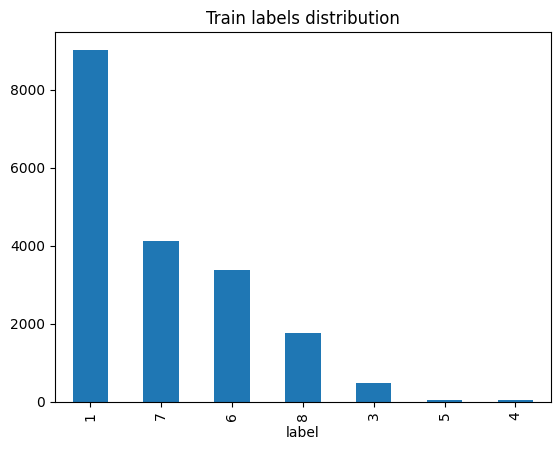

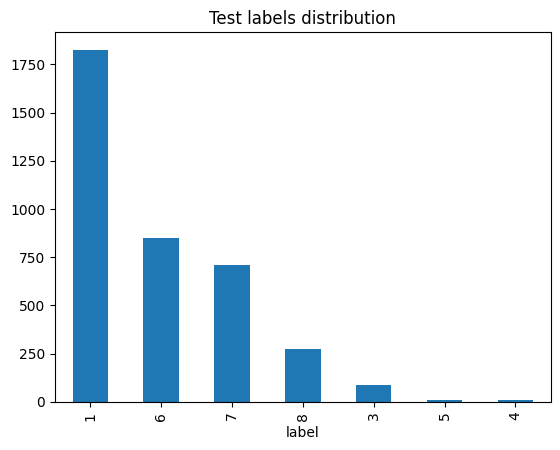

In [110]:
train_df = data[data[id_col].isin(train_subjects)]
test_df = data[data[id_col].isin(test_subjects)]

train_df['label'].value_counts().plot(kind='bar')
plt.title('Train labels distribution')
plt.show()

test_df['label'].value_counts().plot(kind='bar')
plt.title('Test labels distribution')
plt.show()

test_key = test_df[[id_col, time_col, target_col]]
test_df = test_df.drop(columns=[target_col])

## Save data

In [111]:
data.to_csv(full_outp_fname, index=False)
train_df.to_csv(train_outp_fname, index=False)
test_df.to_csv(test_outp_fname, index=False)
test_key.to_csv(test_key_outp_fname, index=False)